In [1]:
import os
import sys
current_dir = os.getcwd()
grand_package_root = os.path.join(current_dir,'..')
sys.path.insert(0, grand_package_root)
print(f"Répertoire racine du package ajouté à sys.path : {grand_package_root}")

Répertoire racine du package ajouté à sys.path : /home/jovyan/persistent/EA_Project/Analysis/..


In [2]:
import numpy as np
import numpy.random as rnd
import itertools
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from IPython import display
import pandas as pd
import time
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# Imports
from Design.Ising import Configuration
from Production.Exact_Energy import exact_1d_ising_energy, compute_relative_error
from Production.RBM_GD import RBM
from Production.RBM_SR import RBMSR


=== Training for chain length N = 50 ===


MemoryError: Unable to allocate 8.00 PiB for an array with shape (1125899906842625,) and data type int64

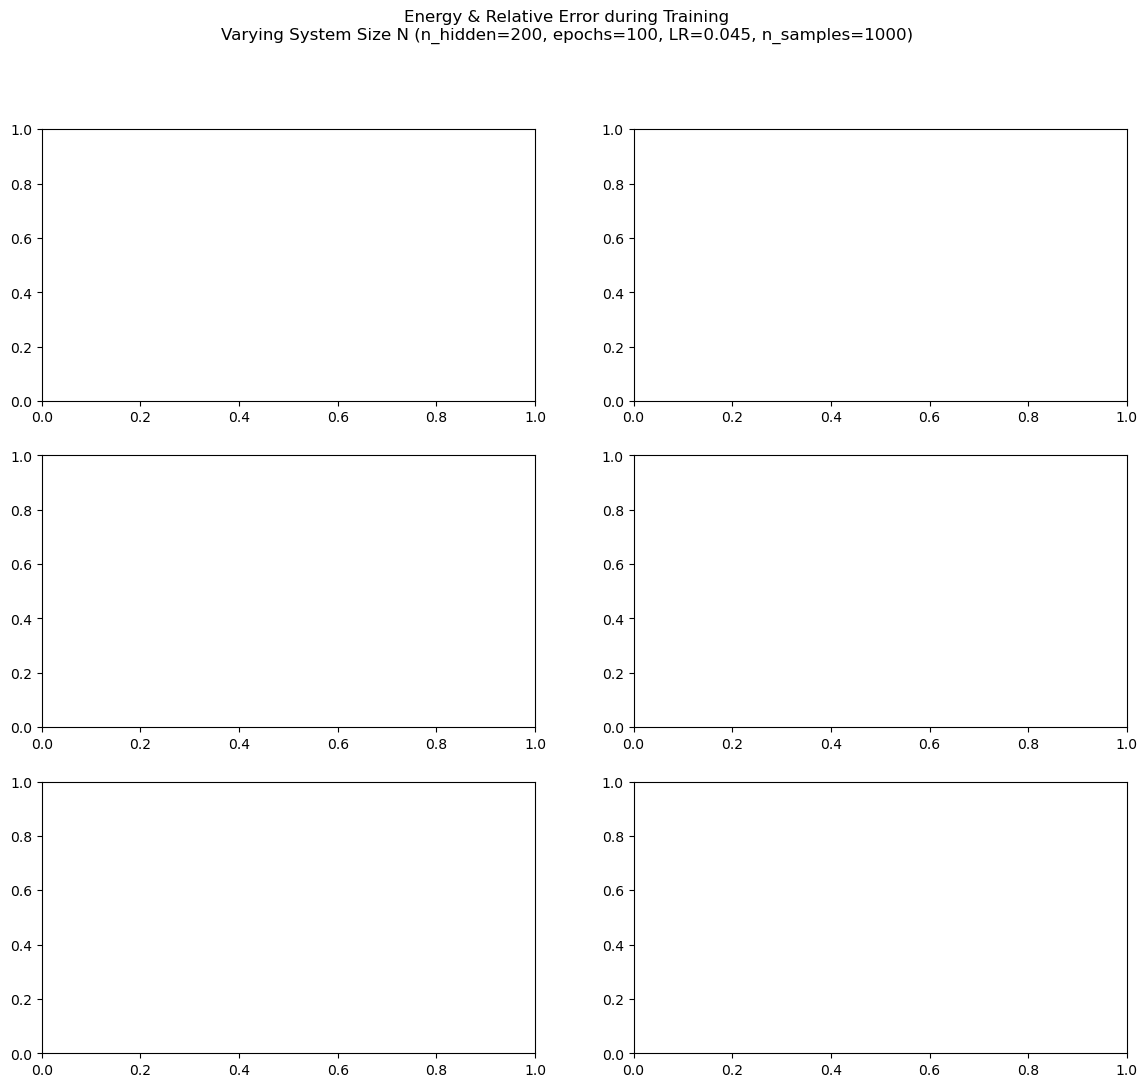

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure RBMSR and exact_1d_ising_energy functions are defined and accessible in your environment.

# General Parameters 
N_list = [50, 100, 200]     
n_hidden = 200                   # Fixed: Number of hidden units
epochs = 100                    # Fixed: Total training epochs
learning_rate = 0.045           # Fixed: Learning rate for RBM-SR
J = 1.0                         # Fixed: Ising coupling constant
H = 1                         # Fixed: External magnetic field
n_samples = 1000               # Fixed: Number of Monte Carlo samples per epoch

# Figure Setup: One row per value of N
fig, axes = plt.subplots(
    nrows=len(N_list),
    ncols=2, # Column 0: Energy, Column 1: Relative Error
    figsize=(14, 4 * len(N_list)) # Adjust figure height dynamically
)

# Global title reflecting the fixed parameters
fig.suptitle(
    f'Energy & Relative Error during Training\n'
    f'Varying System Size N (n_hidden={n_hidden}, epochs={epochs}, LR={learning_rate}, n_samples={n_samples})'
)

# Loop over different chain lengths L 
for i, N in enumerate(N_list):
    print(f"\n=== Training for chain length N = {N} ===")

    # -Exact Energy for the chain N
    # Calculate the exact ground state energy for the 1D Ising chain.
    E_exact = exact_1d_ising_energy(N, J, H, periodic=True)[0]

    # RBM-SR Training for this length L
    # Note: n_visible=L changes in each iteration
    rbm_sr = RBMSR(n_visible=N, n_hidden=n_hidden, seed=42)

    energies_sr, rel_errors_sr = rbm_sr.train(
        n_epochs=epochs,
        n_samples_per_epoch=n_samples,
        learning_rate=learning_rate,
        J=J,
        H=H
    )

    # Select the specific axes for this row (L) 
    ax_energy = axes[i, 0]
    ax_error  = axes[i, 1]

    # Energy Plot (Left Column) 
    ax_energy.plot(energies_sr, label='RBM-SR', color='green', linewidth=2)
    # Add the exact energy as a horizontal line
    ax_energy.axhline(E_exact, color='red', linestyle=':', label='Exact')

    ax_energy.set_ylabel('Energy')
    ax_energy.set_title(f'Energy (N={N}, $2^N = {2**N:.1e}$ states)') # Showing Hilbert space size
    ax_energy.legend()
    ax_energy.grid(True, alpha=0.3)

    #  Relative Error Plot (Right Column) 
    # Use semilogy to plot the relative error on a logarithmic scale
    ax_error.semilogy(np.abs(rel_errors_sr), label='RBM-SR', color='green', linewidth=2)

    ax_error.set_ylabel('Relative Error (log)')
    ax_error.set_title(f'Rel. Error (N={N})')
    ax_error.legend()
    ax_error.grid(True, alpha=0.3)

    # Add X-axis label only on the last row for cleaner plots
    if i == len(N_list) - 1:
        ax_energy.set_xlabel('Epoch')
        ax_error.set_xlabel('Epoch')

# Adjust layout to prevent overlap and make room for the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# We get an error: Attempting to construct the dense Hamiltonian matrix for $N=50$ would require allocating a contiguous memory block for over $10^{15}$ elements, corresponding to approximately 8 Petabytes (PiB) of RAM. This represents an insurmountable "exponential wall" for standard numerical linear algebra.


# We need to apdate the RBMSR class

In [3]:
import numpy as np
import time

class RBMSR:
    """
    RBM optimisé par Stochastic Reconfiguration (SR).
    Version adaptée pour grands systèmes (N > 20) :
    - Pas de calcul d'énergie exacte (évite MemoryError).
    - Suivi de la Variance de l'énergie (V-score) pour valider la convergence.
    """
    def __init__(self, n_visible, n_hidden, seed=None):
        self.N = n_visible
        self.M = n_hidden
        self.rng = np.random.default_rng(seed)
        
        # Initialisation à petite échelle
        scale = 0.01 if self.M < 20 else 0.001
        self.a = scale * self.rng.normal(size=self.N)
        self.b = scale * self.rng.normal(size=self.M)
        self.W = scale * self.rng.normal(size=(self.M, self.N))
        
        # Hyperparamètres SR
        self._l2_reg = 1e-4
        self._grad_clip_norm = 10.0

    def log_psi(self, s):
        """Ln(Psi) vectorisé pour un batch d'états s (shape: batch x N) ou un seul (N,)"""
        if s.ndim == 1:
            visible = np.dot(self.a, s)
            hidden = np.sum(np.logaddexp(self.b + self.W @ s, -(self.b + self.W @ s)))
            return visible + hidden
        else:
            # Batch version
            visible = s @ self.a
            # W.s^T -> (M, N) @ (N, batch) -> (M, batch)
            theta = self.b[:, None] + self.W @ s.T
            hidden = np.sum(np.logaddexp(theta, -theta), axis=0)
            return visible + hidden

    def get_log_psi_ratio(self, s, i):
        """Ratio Psi(s_flipped)/Psi(s) pour un flip au site i (Optimisé)"""
        # Delta_v
        sigma_i = s[i]
        delta_si = -2 * sigma_i
        log_ratio_v = self.a[i] * delta_si
        
        # Delta_h
        theta = self.b + self.W @ s
        delta_theta = self.W[:, i] * delta_si
        theta_new = theta + delta_theta
        
        log_ratio_h = np.sum(np.logaddexp(theta_new, -theta_new) - np.logaddexp(theta, -theta))
        return np.exp(log_ratio_v + log_ratio_h)

    def get_energy_local(self, s, J, H):
        """Energie locale E_loc(s) pour Ising 1D"""
        # Terme diagonal (Interaction zz)
        # Périodique : s[0]*s[1] + ... + s[N-1]*s[0]
        inter = np.sum(s * np.roll(s, -1))
        E_diag = -J * inter
        
        # Terme non-diagonal (Champ transverse x)
        # Somme des ratios de wavefunction
        sum_ratios = 0.0
        for i in range(self.N):
            sum_ratios += self.get_log_psi_ratio(s, i)
        
        # --- CORRECTION ICI (sum_ratios au lieu de sum_of_ratios) ---
        E_off_diag = -H * sum_ratios
        
        return E_diag + E_off_diag

    def sample(self, n_samples, n_burnin=200, J=1.0, H=1.0):
        """Metropolis Sampling simple"""
        # Départ aléatoire
        curr_s = self.rng.choice([-1, 1], size=self.N)
        
        # Burn-in
        for _ in range(n_burnin * self.N):
            i = self.rng.integers(self.N)
            ratio = self.get_log_psi_ratio(curr_s, i)
            prob = ratio**2
            if prob >= 1.0 or self.rng.random() < prob:
                curr_s[i] *= -1
        
        samples = []
        # Sampling (1 sample tous les N flips pour décorréler un peu)
        for _ in range(n_samples):
            for _ in range(self.N): # N steps de Metropolis entre chaque sample
                i = self.rng.integers(self.N)
                ratio = self.get_log_psi_ratio(curr_s, i)
                prob = ratio**2
                if prob >= 1.0 or self.rng.random() < prob:
                    curr_s[i] *= -1
            samples.append(curr_s.copy())
            
        return np.array(samples), None, 0.5 # (samples, placeholder, placeholder rate)

    def compute_gradients(self, samples, J, H):
        """Calcul des gradients SR et de l'énergie locale"""
        n_s = len(samples)
        
        # 1. Calcul des observables O_k (derivées log_psi) et Energies locales
        O_list = []
        E_loc_list = []
        
        for s in samples:
            # Derivées
            theta = self.b + self.W @ s
            tanh_theta = np.tanh(theta)
            
            da = s
            db = tanh_theta
            dW = np.outer(tanh_theta, s).flatten() # Vectorisé
            
            O_vec = np.concatenate([da, db, dW])
            O_list.append(O_vec)
            
            # Energie locale
            E_loc_list.append(self.get_energy_local(s, J, H))
            
        O = np.array(O_list)       # (Ns, N_params)
        E_loc = np.array(E_loc_list) # (Ns,)
        
        # 2. Moyennes
        O_mean = np.mean(O, axis=0)
        E_mean = np.mean(E_loc)
        
        # 3. Forces (Gradients "Euclidiens")
        # F_k = 2 * < (E_loc - <E>) * (O_k - <O_k>) >
        E_centered = E_loc - E_mean
        O_centered = O - O_mean
        F = 2.0 * np.mean(E_centered[:, None] * O_centered, axis=0)
        
        # 4. Matrice S (Covariance)
        # S_kk' = < (O_k - <O_k>) * (O_k' - <O_k'>) >
        # S = (O_c.T @ O_c) / Ns
        S = (O_centered.T @ O_centered) / n_s
        
        # Regularisation (pour inverser S)
        S += self._l2_reg * np.eye(S.shape[0])
        
        # 5. Inversion SR : x = S^-1 F
        # Utilisation de lstsq pour stabilité
        x, _, _, _ = np.linalg.lstsq(S, F, rcond=1e-4)
        
        # Découpage du vecteur update x
        n_a = self.N
        n_b = self.M
        
        ga = x[:n_a]
        gb = x[n_a : n_a+n_b]
        gW = x[n_a+n_b:].reshape(self.M, self.N)
        
        # Clipping global
        norm_g = np.linalg.norm(x)
        if norm_g > self._grad_clip_norm:
            scale = self._grad_clip_norm / norm_g
            ga *= scale
            gb *= scale
            gW *= scale
            
        return ga, gb, gW, E_loc # On retourne toutes les E_loc pour calculer la variance
        
    def train(self, n_epochs, n_samples_per_epoch, learning_rate, J, H, verbose=True):
        """Boucle d'entraînement qui retourne Energies et Variances"""
        energy_history = []
        variance_history = []
        
        for ep in range(n_epochs):
            # 1. Sampling
            samples, _, _ = self.sample(n_samples_per_epoch, J=J, H=H)
            
            # 2. SR Gradients & Energies Locales
            ga, gb, gW, local_energies = self.compute_gradients(samples, J, H)
            
            # 3. Stats (Moyenne et Variance)
            E_mean = np.mean(local_energies)
            E_var = np.var(local_energies) # <--- V-SCORE
            
            energy_history.append(E_mean)
            variance_history.append(E_var)
            
            # 4. Update
            self.a -= learning_rate * ga
            self.b -= learning_rate * gb
            self.W -= learning_rate * gW
            
            if verbose and (ep % 10 == 0):
                print(f"Ep {ep}: E/N={E_mean/self.N:.4f}, Var/N={E_var/self.N:.2e}")
                
        return energy_history, variance_history

# Example 


=== Training N = 50 ===
Ep 0: E/N=-1.0000, Var/N=9.62e-01
Ep 10: E/N=-1.1437, Var/N=4.97e-01
Ep 20: E/N=-1.2503, Var/N=7.94e-02
Ep 30: E/N=-1.2628, Var/N=5.14e-02
Ep 40: E/N=-1.2624, Var/N=4.33e-02
Ep 50: E/N=-1.2678, Var/N=3.95e-02


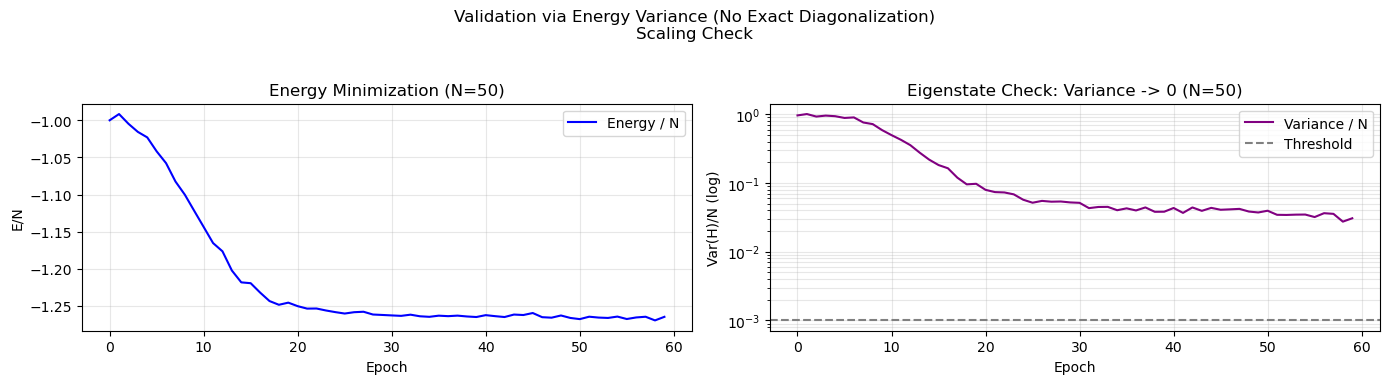

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N_list = [50]  
n_hidden = 100
epochs = 60
learning_rate = 0.04
n_samples = 600
J = 1.0
H = 1.0

# Figures 
fig, axes = plt.subplots(
    nrows=len(N_list), 
    ncols=2, 
    figsize=(14, 4 * len(N_list)),
    squeeze=False  # <--- FIX 1: Force axes to always be 2D
)
fig.suptitle(
    "Validation via Energy Variance (No Exact Diagonalization)\n"
    "Scaling Check"
)

for i, N in enumerate(N_list):
    print(f"\n=== Training for N = {N} ===")
    
    # RBM initialization (make sure the RBMSR class is properly defined beforehand)
    rbm = RBMSR(n_visible=N, n_hidden=n_hidden, seed=42)
    
    # Training
    ens, vars_ = rbm.train(epochs, n_samples, learning_rate, J, H, verbose=True)
    
    # Normalization
    ens = np.array(ens) / N
    vars_ = np.array(vars_) / N
    
    #Plotting 
    # Thanks to squeeze=False, axes is always indexed as [row, column]
    ax_e = axes[i, 0]
    ax_v = axes[i, 1]
    
    # Energy plot
    ax_e.plot(ens, color='blue', label='Energy / N')
    ax_e.set_title(f'Energy Minimization (N={N})')
    ax_e.set_ylabel('E/N')
    ax_e.legend()
    ax_e.grid(True, alpha=0.3)
    
    # Variance plot (V-score)
    ax_v.semilogy(vars_, color='purple', label='Variance / N')
    ax_v.set_title(f'Eigenstate Check: Variance → 0 (N={N})')
    ax_v.set_ylabel('Var(H)/N (log scale)')
    ax_v.axhline(1e-3, color='gray', linestyle='--', label='Threshold')
    ax_v.legend()
    ax_v.grid(True, alpha=0.3, which='both')
    
    if i == len(N_list) - 1:
        ax_e.set_xlabel('Epoch')
        ax_v.set_xlabel('Epoch')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# We change parameters


=== Training N = 50 ===
Ep 0: E/N=-1.0023, Var/N=1.00e+00
Ep 10: E/N=-1.1579, Var/N=3.86e-01
Ep 20: E/N=-1.2596, Var/N=4.45e-02
Ep 30: E/N=-1.2635, Var/N=3.30e-02
Ep 40: E/N=-1.2656, Var/N=3.05e-02
Ep 50: E/N=-1.2675, Var/N=2.63e-02
Ep 60: E/N=-1.2697, Var/N=1.99e-02
Ep 70: E/N=-1.2695, Var/N=2.03e-02
Ep 80: E/N=-1.2713, Var/N=1.79e-02
Ep 90: E/N=-1.2694, Var/N=1.39e-02


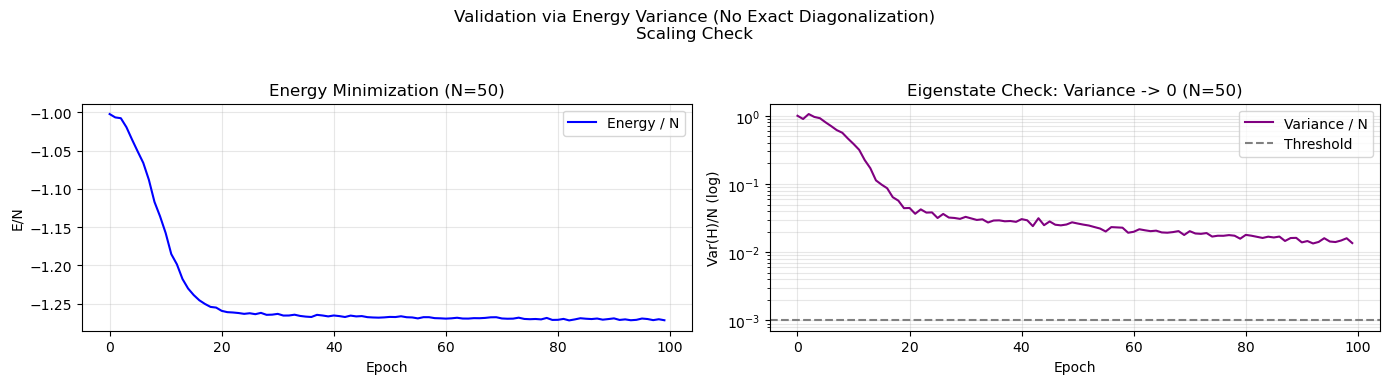

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters 
N_list = [50]  
n_hidden = 100
epochs = 100
learning_rate = 0.04
n_samples = 800
J = 1.0
H = 1.0

# Figures 
fig, axes = plt.subplots(
    nrows=len(N_list), 
    ncols=2, 
    figsize=(14, 4 * len(N_list)),
    squeeze=False  # <--- FIX 1: Force axes to always be 2D
)
fig.suptitle(
    "Validation via Energy Variance (No Exact Diagonalization)\n"
    "Scaling Check"
)

for i, N in enumerate(N_list):
    print(f"\n=== Training for N = {N} ===")
    
    # RBM initialization (make sure the RBMSR class is properly defined beforehand)
    rbm = RBMSR(n_visible=N, n_hidden=n_hidden, seed=42)
    
    # Training
    ens, vars_ = rbm.train(epochs, n_samples, learning_rate, J, H, verbose=True)
    
    # Normalization
    ens = np.array(ens) / N
    vars_ = np.array(vars_) / N
    
    # Plotting 
    # Thanks to squeeze=False, axes is always indexed as [row, column]
    ax_e = axes[i, 0]
    ax_v = axes[i, 1]
    
    # Energy plot
    ax_e.plot(ens, color='blue', label='Energy / N')
    ax_e.set_title(f'Energy Minimization (N={N})')
    ax_e.set_ylabel('E/N')
    ax_e.legend()
    ax_e.grid(True, alpha=0.3)
    
    # Variance plot (V-score)
    ax_v.semilogy(vars_, color='purple', label='Variance / N')
    ax_v.set_title(f'Eigenstate Check: Variance → 0 (N={N})')
    ax_v.set_ylabel('Var(H)/N (log scale)')
    ax_v.axhline(1e-3, color='gray', linestyle='--', label='Threshold')
    ax_v.legend()
    ax_v.grid(True, alpha=0.3, which='both')
    
    if i == len(N_list) - 1:
        ax_e.set_xlabel('Epoch')
        ax_v.set_xlabel('Epoch')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



=== Training N = 50 ===
Ep 0: E/N=-1.0025, Var/N=9.89e-01
Ep 10: E/N=-1.1968, Var/N=2.25e-01
Ep 20: E/N=-1.2616, Var/N=3.07e-02
Ep 30: E/N=-1.2655, Var/N=2.86e-02
Ep 40: E/N=-1.2675, Var/N=2.24e-02
Ep 50: E/N=-1.2699, Var/N=2.00e-02
Ep 60: E/N=-1.2705, Var/N=1.63e-02
Ep 70: E/N=-1.2704, Var/N=1.46e-02
Ep 80: E/N=-1.2707, Var/N=1.15e-02
Ep 90: E/N=-1.2720, Var/N=1.17e-02
Ep 100: E/N=-1.2711, Var/N=9.51e-03
Ep 110: E/N=-1.2720, Var/N=1.03e-02
Ep 120: E/N=-1.2729, Var/N=8.26e-03
Ep 130: E/N=-1.2720, Var/N=7.76e-03
Ep 140: E/N=-1.2730, Var/N=7.69e-03


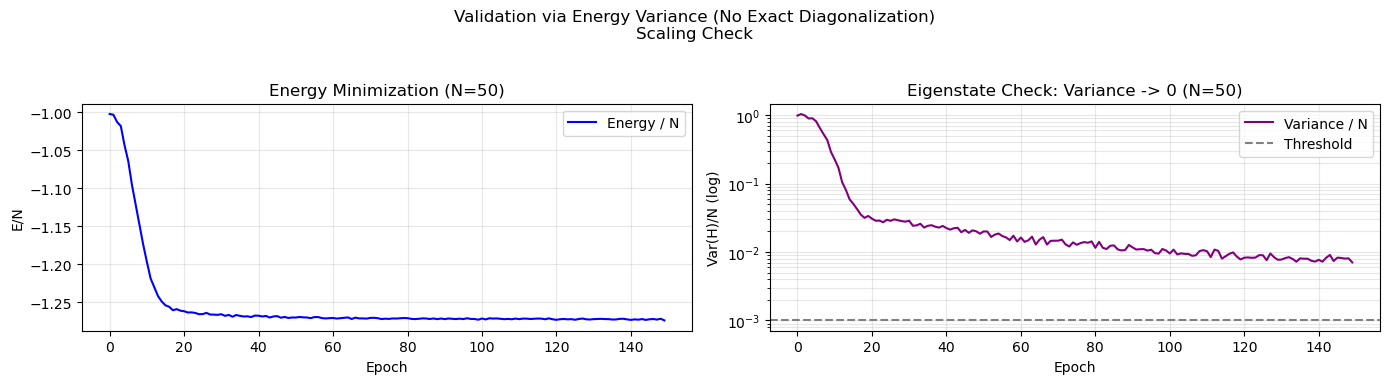

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#  Parameters 
# You can test with a single N or multiple values; it will no longer crash.
N_list = [50]  
n_hidden = 100
epochs = 150
learning_rate = 0.045
n_samples = 1000
J = 1.0
H = 1.0

# Figures 
fig, axes = plt.subplots(
    nrows=len(N_list), 
    ncols=2, 
    figsize=(14, 4 * len(N_list)),
    squeeze=False  # <--- FIX 1: Force axes to always be 2D
)
fig.suptitle(
    "Validation via Energy Variance (No Exact Diagonalization)\n"
    "Scaling Check"
)

for i, N in enumerate(N_list):
    print(f"\n=== Training for N = {N} ===")
    
    # RBM initialization (make sure the RBMSR class is properly defined beforehand)
    rbm = RBMSR(n_visible=N, n_hidden=n_hidden, seed=42)
    
    # Training
    ens, vars_ = rbm.train(epochs, n_samples, learning_rate, J, H, verbose=True)
    
    # Normalization
    ens = np.array(ens) / N
    vars_ = np.array(vars_) / N
    
    #  Plotting 
    # Thanks to squeeze=False, axes is always indexed as [row, column]
    ax_e = axes[i, 0]
    ax_v = axes[i, 1]
    
    # Energy plot
    ax_e.plot(ens, color='blue', label='Energy / N')
    ax_e.set_title(f'Energy Minimization (N={N})')
    ax_e.set_ylabel('E/N')
    ax_e.legend()
    ax_e.grid(True, alpha=0.3)
    
    # Variance plot (V-score)
    ax_v.semilogy(vars_, color='purple', label='Variance / N')
    ax_v.set_title(f'Eigenstate Check: Variance → 0 (N={N})')
    ax_v.set_ylabel('Var(H)/N (log scale)')
    ax_v.axhline(1e-3, color='gray', linestyle='--', label='Threshold')
    ax_v.legend()
    ax_v.grid(True, alpha=0.3, which='both')
    
    if i == len(N_list) - 1:
        ax_e.set_xlabel('Epoch')
        ax_v.set_xlabel('Epoch')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
